In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
item = pd.read_csv('C:/Users/lizil/Dropbox/Job/Data/grocery/item_to_id.csv')

In [4]:
item.head(10)

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39
5,dinner rolls,37
6,tortillas,34
7,bagels,13
8,canned vegetables,28
9,spaghetti sauce,26


In [5]:
item.isnull().sum()

Item_name    0
Item_id      0
dtype: int64

In [6]:
item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
Item_name    48 non-null object
Item_id      48 non-null int64
dtypes: int64(1), object(1)
memory usage: 848.0+ bytes


In [7]:
purchase = pd.read_csv('C:/Users/lizil/Dropbox/Job/Data/grocery/purchase_history.csv')

In [8]:
purchase.head(10)

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."
5,409803,"43,29,8,37,23,45"
6,1296632,"18,15,31,11,20,32,25,6,47"
7,748280,"14,43,6,20,7,42,41,28,10,22,46"
8,31625,"1,43,31,37,25,32,28,35"
9,987613,"27,1,3,2,11,45,10,44,15"


In [9]:
purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39474 entries, 0 to 39473
Data columns (total 2 columns):
user_id    39474 non-null int64
id         39474 non-null object
dtypes: int64(1), object(1)
memory usage: 616.9+ KB


# Data Processing

In [10]:
def id_to_item(df):
    """ function to convert id into counts """
    # 'sum' here is adding two lists into one big list
    ids = df['id'].str.split(',').sum()
    id_list = [0 for i in range(1, 49)]
    for i in ids:
        id_list[int(i) - 1] += 1
        
    return pd.Series(id_list, index=list(range(1, 49)))

In [11]:
user_item_count = purchase.groupby('user_id').apply(id_to_item)

user_item_count.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


# Question 1

The company founder wants to meet with some of the best customers to go through a focus group with them. You are asked to send the ID of the following customers to the founder:
1. the customer who bought the most items overall in her lifetime
2. for each item, the customer who bought that product the most

## Find the ID with Most Purchase of All Time

In [12]:
purchase_sum = user_item_count.sum(axis = 1).reset_index()

In [13]:
purchase_sum.head(10)

,user_id,0
0,47,13
1,68,8
2,113,11
3,123,4
4,223,11
5,281,9
6,323,15
7,394,10
8,420,15
9,453,8


In [14]:
purchase_rank = purchase_sum.sort_values(0,ascending = False)

In [15]:
purchase_rank.head(10)

,user_id,0
4445,269335,72
6111,367872,70
6623,397623,64
9918,599172,64
6291,377284,63
24621,1485538,62
15193,917199,62
11898,718218,60
10799,653800,60
22152,1341188,58


The ID of the user purchase the most items are 269335, with the total quantity pf 72

## Most Purchase of Each Item

In [16]:
item_most = user_item_count.apply(np.argmax, axis = 0).reset_index()

In [20]:
item_most.head(10)

,Item_id,User_Id
0,1,31625
1,2,31625
2,3,154960
3,4,5289
4,5,217277
5,6,334664
6,7,175865
7,8,151926
8,9,269335
9,10,618914


In [19]:
item_most.columns = ['Item_id', 'User_Id']

In [21]:
df = pd.merge(left = item_most, right = item, how = 'left', on='Item_id')

In [22]:
df.head(10)

,Item_id,User_Id,Item_name
0,1,31625,sugar
1,2,31625,lettuce
2,3,154960,pet items
3,4,5289,baby items
4,5,217277,waffles
5,6,334664,poultry
6,7,175865,sandwich bags
7,8,151926,butter
8,9,269335,soda
9,10,618914,carrots


# Question 2

Cluster items based on user co-purchase history. That is, create clusters of products that have the highest probability of being bought together. The goal of this is to replace the old/manually created categories with these new ones. Each item can belong to just one cluster.

Basic Idea: to transpose the data frame, making item as the obs. Then use the KMeans Cluster Analysis to group the products based on their purchase history.

In [23]:
feature = user_item_count.T
feature.head(10)

user_id,47,68,113,123,223,281,323,394,420,453,...,1499502,1499523,1499563,1499702,1499727,1499730,1499778,1499797,1499817,1499974
1,0,0,0,0,1,0,1,1,0,1,...,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,1,1,1,...,1,0,1,0,0,0,1,0,2,0
3,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0,1,0,0,1,0,1,0,0,0,...,0,1,1,1,0,0,1,1,1,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
9,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
10,0,1,0,1,0,0,0,1,1,1,...,0,0,0,0,1,0,0,0,2,1


In [24]:
feature.shape

(48, 24885)

In [25]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

## Set up grid search to find best K

In [30]:
clusters = range(2,30)
inertias = []
silhouettes = []

for cluster in clusters:
    kmeans = KMeans(n_clusters = cluster, random_state = 42, init = 'k-means++',n_jobs=-1)
    kmeans = kmeans.fit(feature)
    label = kmeans.predict(feature)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(feature, label))

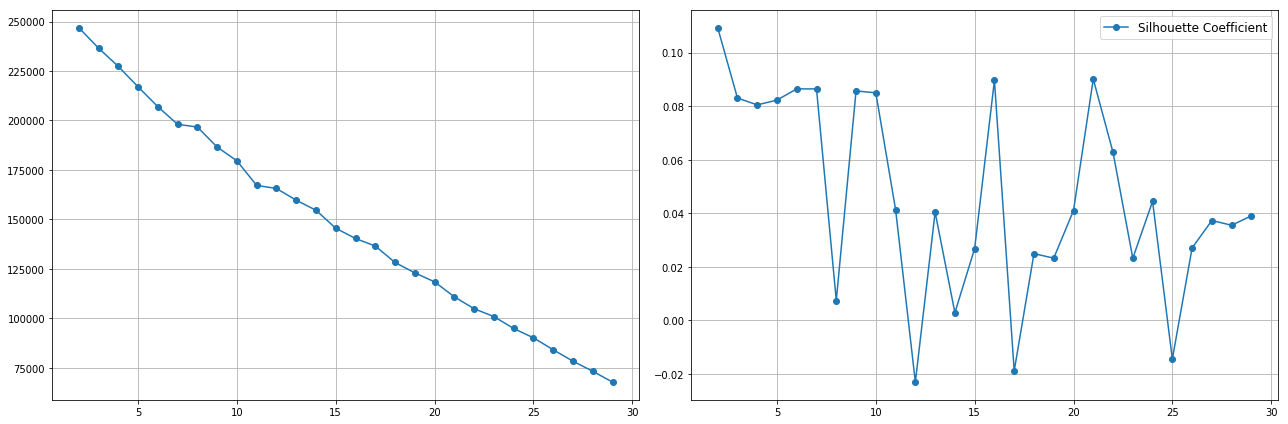

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(clusters, inertias, 'o-', label='Sum of Squared Distances')
ax[0].grid(True)
ax[1].plot(clusters, silhouettes, 'o-', label='Silhouette Coefficient')
ax[1].grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

silhouettes score => another way of estimating the clustering performance
explanation: https://en.wikipedia.org/wiki/Silhouette_(clustering)

Summary:
For any point in the dataset, define two metrics:
a(i): the mean distance among i and all other points in the same cluster with i. It depicts how similar i is with other in-group points
b(i): the SMALLEST mean distance among i and the points in other clusters. You need to calculate the mean distance between i and each other clusters' points, then find the smallest. It depicts the next cloest cluster i belongs to

SC(i) = (b(i) - a(i))/max(a(i),b(i))
SC(k): if the whole data is clustered in k subgroups, the silhouettes effecient will be the mean of silhouettes score of all data points in the dataset.

-1 <= SC <= 1
SC = 1: good cluster
SC = 0: point i is in difference between the current cluster and the next closest one
SC = -1: point i should rather belong to the next cloest cluster

The higher of SC, the better of cluster performance. 

In [32]:
## Decided to use the K=21
kmeans = KMeans(n_clusters=21, init='k-means++', random_state=42, n_jobs=-1)
kmeans = kmeans.fit(feature)
label = kmeans.predict(feature)

In [39]:
df = pd.DataFrame({'Item_id': list(range(1, 49)), 'label': label})
df = pd.merge(left=df, right=item, on='Item_id', how='left')

for i in range(0, 21):
    print(i, '\t', list(df[df['label'] == i]['Item_name']))

0 	 ['pet items', 'baby items', 'waffles', 'sandwich bags', 'butter', 'cereals', 'shampoo', 'eggs', 'aluminum foil', 'milk', 'laundry detergent', 'shaving cream', 'cheeses', 'frozen vegetables', 'paper towels', 'spaghetti sauce', 'dishwashing\xa0', 'canned vegetables', 'hand soap', 'flour', 'pasta', 'toilet paper', 'soap', 'ice cream', 'ketchup', 'yogurt']
1 	 ['bananas']
2 	 ['cauliflower']
3 	 ['sugar']
4 	 ['dinner rolls']
5 	 ['cherries']
6 	 ['beef']
7 	 ['carrots']
8 	 ['lettuce']
9 	 ['coffee']
10 	 ['poultry', 'pork']
11 	 ['bagels', 'tortillas']
12 	 ['broccoli']
13 	 ['berries']
14 	 ['soda']
15 	 ['apples']
16 	 ['cucumbers']
17 	 ['grapefruit']
18 	 ['sandwich loaves']
19 	 ['juice']
20 	 ['tea']


Using KMeans did not cluster the items well. But we can still learn this idea. The general step is: => the key phrase in the problem is "items of highest probability of being purchased together".
1. List the parameter you would like to cluster (items in this dataset) as obs and the other parameters as columns.
2. Grid search the best K 
3. use the best K to fit the wholedata, and get the label
4. print the item under each cluster.